In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [4]:
audio_data = './genres_original/classical/classical.00096.wav'
data , sr = librosa.load(audio_data)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [5]:
data , sr = librosa.load(audio_data)

In [6]:
librosa.load(audio_data, sr=45600)

(array([-0.08003321, -0.10589562, -0.09959807, ..., -0.06361606,
        -0.05566827, -0.02777512], dtype=float32),
 45600)

# Playing Audio

In [7]:
import IPython
IPython.display.Audio(data, rate=sr)

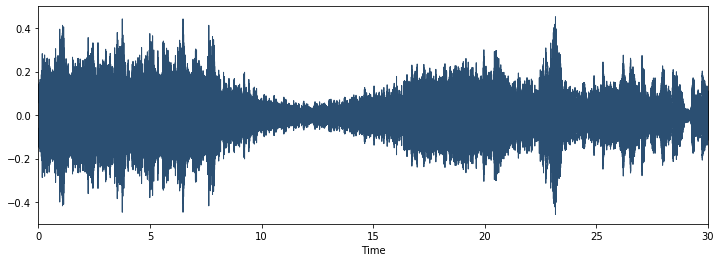

In [8]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, color = "#2B4F72")
plt.show()

Plot Spectrogram:

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

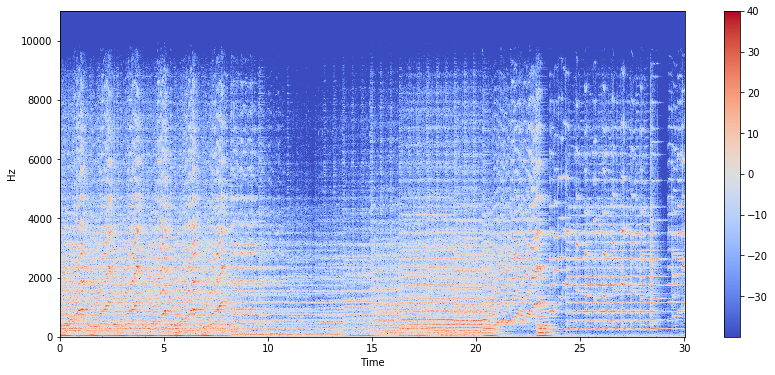

In [9]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.

Let's Convert the frequency axis to a logarithm , because we see that all actions (in red) is taking place at the bottom of the spectrum.

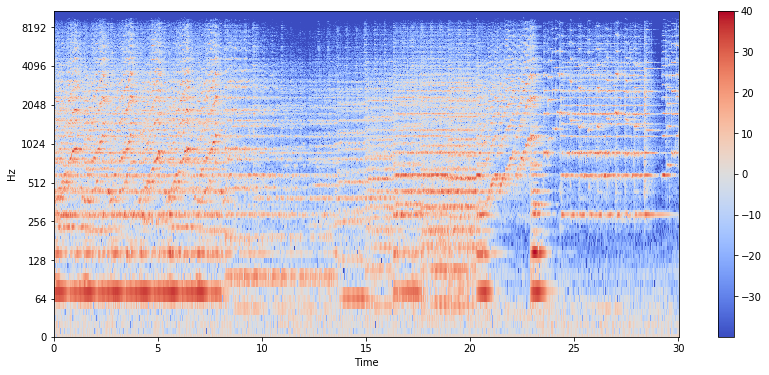

In [10]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

Spectral Rolloff

is the frequency below which a specified percentage of the total spectral energy

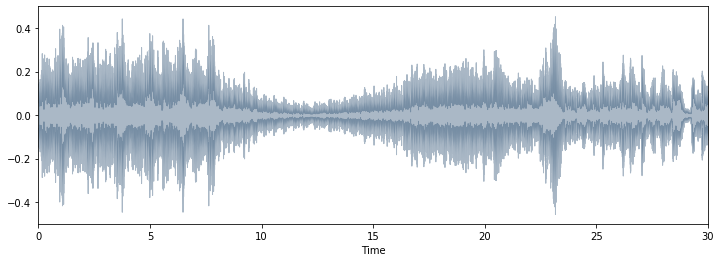

In [11]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color = "#2B4F72")

Zero-Crossing Rate:

a zero crossing is said to occur if successive samples have different algebraic signs. The rate at which zero crossings occur is a simple measure of the frequency content of a signal. Zero-crossing rate is a measure of number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero

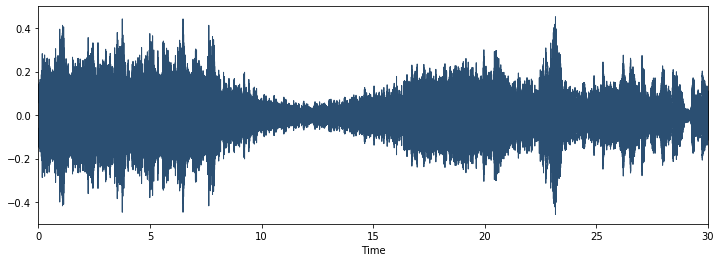

In [12]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr, color="#2B4F72")

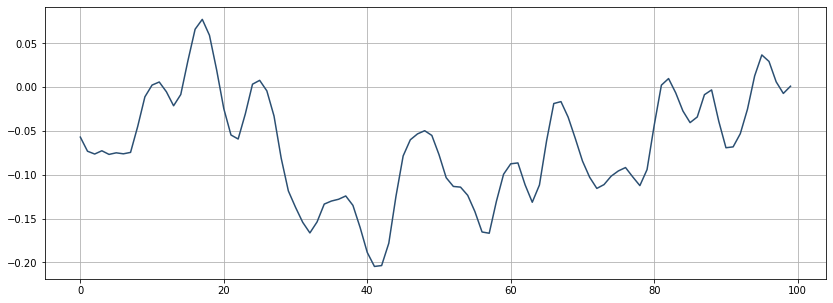

In [13]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(data[n0:n1], color="#2B4F72")
plt.grid()

The graph shows 11 zero crossings. Let’s verify it with Librosa.

In [14]:
zero_crossings = librosa.zero_crossings(data[n0:n1], pad=False)
print("The number of zero-crossings is :",sum(zero_crossings))

The number of zero-crossings is : 11


Chroma feature

is a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

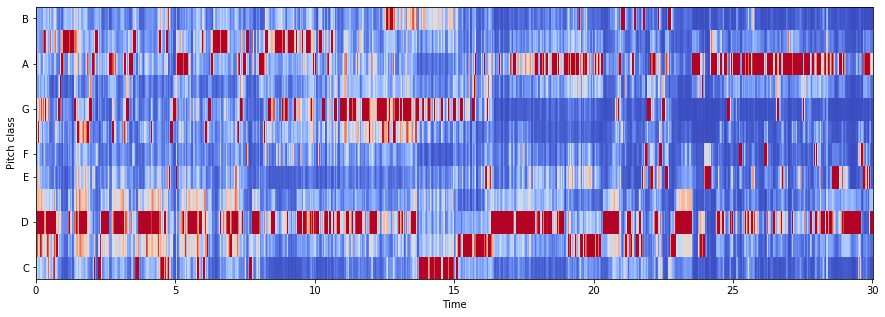

In [15]:
chromagram = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')

# Classification

Our Datasets contains 10 genres :

Blues

Classical

Country

Disco

Hiphop

Jazz

Metal

Pop

Reggae

Rock



In [16]:
%matplotlib inline
from keras import layers
import keras

In [17]:
df1 = pd.read_csv('features_3_sec.csv')
df1.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# Data Cleaning 
We will drop the first column of "filename":

In [18]:
df1 = df1.drop(labels='filename',axis=1)

Preprocessing the Data

We will now focus on the last column "label" the categorical column and we will try to encode it with the function LabelEncoder() of sklearn.preprocessing.

In [19]:
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()

In [20]:
y = encoder.fit_transform(genre_list)

In [21]:
print(df1.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [25]:
from keras.models import Sequential

In [26]:
# Neural network
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
53/53 [==============================] - 0s 2ms/step - loss: 1.5100 - accuracy: 0.4763
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 0.9097 - accuracy: 0.6882
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.7090 - accuracy: 0.7620
Epoch 4/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5902 - accuracy: 0.8032
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.8315
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8524
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8743
Epoch 8/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3239 - accuracy: 0.8962
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.9104
Epoch 10/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2444 - accuracy: 0.9268
Epoch 11/

53/53 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 83/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9976
Epoch 84/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9982
Epoch 85/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9985
Epoch 86/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9988
Epoch 87/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.9988
Epoch 88/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 89/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9982
Epoch 90/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.9981
Epoch 91/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9988
Epoch 92/100


In [28]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)

26/26 [==============================] - 0s 1ms/step - loss: 0.6447 - accuracy: 0.8941


In [29]:
print("The test loss is :",test_loss, "\nThe test accuracy is :",test_acc)

The test loss is : 0.6447204351425171 
The test accuracy is : 0.894146203994751
